In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import scikitplot as skplt
from sklearn import metrics

In [2]:
df= pd.read_csv('./data/positive_emotion_dataset.csv').drop(columns='Unnamed: 0')
df

,ad,pos_emo
0,i am proud and excited to be your mayor\nalex ...,1
1,proud to work with rep andy kim to secure mil...,1
2,in recent days i have received many questions ...,1
3,this is a fantastic idea we need to stopkavan...,1
4,in these deeply divided times connecting commu...,1
...,...,...
19995,from maggie thatcher to theresa may i know whi...,0
19996,vote is available in many areas across north ...,0
19997,you have to register before you can vote,0
19998,dana balter would put washington bureaucrats i...,0


In [3]:
norm_train,  norm_test, y_train, y_test  = train_test_split(df['ad'], df['pos_emo'], test_size =0.2  , random_state = 42)

In [7]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('httpbitlytvbrc', 45187), ('<PAD>', 0), 1)

In [9]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [10]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((16000, 1000), (4000, 1000))

In [11]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [12]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         5784064   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [14]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
400/400 [==============================] - 66s 162ms/step - loss: 0.5460 - accuracy: 0.7215 - val_loss: 0.3275 - val_accuracy: 0.8984
Epoch 2/5
400/400 [==============================] - 52s 129ms/step - loss: 0.2273 - accuracy: 0.9150 - val_loss: 0.1662 - val_accuracy: 0.9525
Epoch 3/5
400/400 [==============================] - 52s 130ms/step - loss: 0.1102 - accuracy: 0.9632 - val_loss: 0.1113 - val_accuracy: 0.9663
Epoch 4/5
400/400 [==============================] - 52s 129ms/step - loss: 0.0571 - accuracy: 0.9820 - val_loss: 0.0981 - val_accuracy: 0.9672
Epoch 5/5
400/400 [==============================] - 52s 130ms/step - loss: 0.0339 - accuracy: 0.9907 - val_loss: 0.0947 - val_accuracy: 0.9659


In [15]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

125/125 [==============================] - 1s 8ms/step - loss: 0.0963 - accuracy: 0.9672
Accuracy: 96.72%


In [16]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

125/125 [==============================] - 1s 7ms/step


[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]

              precision    recall  f1-score   support

 no-scarcity       0.96      0.97      0.97      2015
    scarcity       0.97      0.96      0.97      1985

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

confusion matrix:
[[1962   53]
 [  78 1907]]



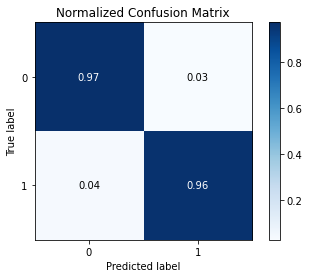

In [18]:
print(metrics.classification_report(y_test, predictions, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [4]:
save = pd.read_csv('./data/sample_pos_emo.csv')
save

,ad,pos_emo
0,see why everyone is celebrating at hoblit dodg...,1
1,help give people without a home a chance to le...,0
2,i am so proud of what this grassroots team has...,1
3,we have until march 31st to raise money for ou...,0
4,learn how to use the new staffing law to impro...,0
...,...,...
120,blood donation saves lives\nthis cannot be sai...,0
121,over 10000 palestinians have been forced left ...,0
122,palestine emergency appeal 53 palestinians inc...,0
123,let is build cameroon wake up cameroonians and...,1


Accuracy: 72.80%
confusion matrix:
[[84 14]
 [20  7]]



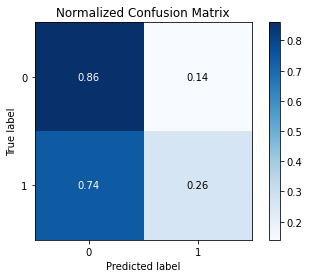

In [23]:
norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['pos_emo'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))

print("confusion matrix:")
print(metrics.confusion_matrix(save['pos_emo'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['pos_emo'], save['predicted'], normalize=True)
plt.show()

In [24]:
print(metrics.classification_report(save['pos_emo'],save['predicted'], target_names=[ 'no-pos', 'pos']))

              precision    recall  f1-score   support

      no-pos       0.81      0.86      0.83        98
         pos       0.33      0.26      0.29        27

    accuracy                           0.73       125
   macro avg       0.57      0.56      0.56       125
weighted avg       0.71      0.73      0.72       125

